# 4. Multiple Machine Learning models
To see which models perform best, I found a way to visualise accuracy of multiple models into one diagram.

## Preprocessing
First, lets do the necessary importing and processing to be able to work with the data.

In [4]:
import pandas as pd
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from preprocessing import PreProcessor

pp = PreProcessor()

df = pd.read_csv('darkweb/data/agora.csv')

categories_main = df[' Category'].apply(lambda x: x.split('/')[0])
descriptions = df[' Item'] + " " + df[' Item Description']
descriptions_preprocessed = descriptions.apply(lambda d: pp.preprocess(str(d)))

df = pd.DataFrame({'Category': categories_main, 'Item Description': descriptions_preprocessed})
df = df[pd.notnull(df['Item Description'])] # no empty descriptions
df = df[df.groupby('Category')['Category'].transform(len) > 1] # only categories that appear more than once

df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))
features = tfidf.fit_transform(df['Item Description'])
labels = df.category_id

df.head()

,Category,Item Description,category_id
0,Services,month huluplu gift code month huluplu code wor...,0
1,Services,pay tv sky uk sky germani hd tv much cccam ser...,0
2,Services,offici account creator extrem tag submiss fix ...,0
3,Services,vpn tor sock tutori setup vpn tor sock super s...,0
4,Services,facebook hack guid guid teach hack facebook ac...,0


## Naive Bias
After the preprocessing, let's try a single model first. We devide the data into a trianing- and test set first. Then, we train the model. After the model is trained, we can simply type a test sentence and see what category the model thinks sentence belongs to. The model seems to be right in this case.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Item Description'], df['Category'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# Naive Bayes Classifier: the one most suitable for word counts is the multinomial variant:
clf = MultinomialNB().fit(X_train_tfidf, y_train)

print(clf.predict(count_vect.transform(["I am offering a shitload of grass"])))

['Drugs']


## Multiple models
Now that we have trained multiple models, it is time to see how different ones perform on our data.
We train the following models: 

Logistic Regression, Multinomial) Naive Bayes, Linear Support Vector Machine, Random Forest and SGDCClassifier

After the training, we plot the results to see which one scores best.

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


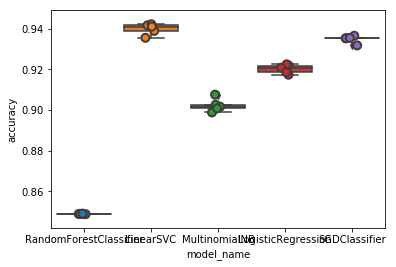

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    SGDClassifier(loss='hinge', penalty='l2', alpha=1e-5, max_iter=1000, tol=1e-3, class_weight='balanced')
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

plt.show()

After we plotted the results, we can also check the exact numbers:

In [8]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.939874
LogisticRegression        0.920245
MultinomialNB             0.902296
RandomForestClassifier    0.848941
SGDClassifier             0.934882
Name: accuracy, dtype: float64